### T W I N - D E L A Y E D-3 + B C

In [1]:
# IMPORTs

import torch
torch.set_float32_matmul_precision('highest')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import h5py
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import copy


### D E V I C E 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')


Device: cuda


In [3]:
writer = SummaryWriter(log_dir="./runs/td3_bc")


### D A T A S E T 

In [4]:
path = 'C:\OFFLINE RL\hopper_medium-v2.hdf5'

with h5py.File(path, 'r') as f:
    
    observations = np.array(f['observations'])
    next_obs = np.array(f['next_observations'])
    actions = np.array(f['actions'])
    rewards = np.array(f['rewards'])
    terminals = np.array(f['terminals'])
    timeouts = np.array(f['timeouts'])
    
state_dim = observations.shape[1]
action_dim = actions.shape[1]
max_action = np.abs(actions).max()

print(f'Number of samples: {len(observations)}')
print(f'state dim: {state_dim} | action dim: {action_dim} | max action: {max_action}')


Number of samples: 1000000
state dim: 11 | action dim: 3 | max action: 0.9999945163726807


### S E T U P

In [5]:
obs_tensor = torch.from_numpy(observations).float().to(device)
act_tensor = torch.from_numpy(actions).float().to(device)
rew_tensor = torch.from_numpy(rewards).float().to(device)
next_obs_tensor = torch.from_numpy(next_obs).float().to(device)

dones = terminals | timeouts
don_tensor = torch.from_numpy(dones).float().to(device)

batch_size = 256

class Hopper_Dataset(Dataset):
    
    def __init__(self, obs, act, rew, dones, next_obs):
        
        self.observations = obs
        self.actions = act
        self.rewards = rew
        self.dones = dones
        self.next_obs = next_obs
        
    def __len__(self):
        
        return len(self.observations)
    
    def __getitem__(self, index):
        
        return  self.observations[index], self.actions[index], self.rewards[index],self.dones[index], self.next_obs[index]
    

dataset = Hopper_Dataset(obs_tensor, act_tensor, rew_tensor, don_tensor, next_obs_tensor)

train_data, test_data = train_test_split(dataset, test_size = 0.2)

train_loader, test_loader = DataLoader(train_data, batch_size, shuffle = True, drop_last = True), DataLoader(test_data, batch_size, shuffle = True, drop_last = True)


### A S S E M B L Y

In [6]:
# neurons

head_1 = 128
head_2 = 256
head_3 = 256
head_4 = 128

# feature

hidden_size = 128
hidden_size_2 = 256


### F E A T U R E 

In [7]:
class Feature_Extractor(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_size = hidden_size, hidden_size_2 = hidden_size_2):
        super(Feature_Extractor, self).__init__()
        
        self.cal = nn.Sequential(
            
            nn.Linear(input_dim, hidden_size),
            nn.SiLU(),
            
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size_2),
            nn.SiLU(),
            
            nn.Linear(hidden_size_2, hidden_size_2),
            nn.SiLU(),
            
            nn.LayerNorm(hidden_size_2),
            nn.Linear(hidden_size_2, hidden_size),
            nn.SiLU(),
            
            nn.Linear(hidden_size, output_dim),
            nn.SiLU()
        )
        
    def forward(self, x):
    
        return self.cal(x)


### P O L I C Y

In [8]:
class policy_net(nn.Module):
    
    def __init__(self, state_dim = state_dim, action_dim = action_dim, max_action = max_action, head_1 = head_1, head_2 = head_2, head_3 = head_3, head_4 = head_4):
        super(policy_net, self).__init__()
        
        # feature
        
        self.feature = Feature_Extractor(state_dim, head_1)
        
        # norm
        
        self.norm = nn.LayerNorm(head_1)
        
        # pos feature
        
        self.pos_feature = nn.Sequential(
            
            nn.Linear(head_1, head_2),
            nn.SiLU(),
            
            nn.LayerNorm(head_2),
            nn.Linear(head_2, head_3),
            nn.SiLU(),
            
            nn.LayerNorm(head_3),
            nn.Linear(head_3, head_4),
            nn.SiLU()
        )
        
        # mu and log std
        
        self.mu = nn.Linear(head_4, action_dim)
        
        # max action
        
        self.max_action = max_action
        
    def forward(self, state):
        
        # feature
        
        feature = self.feature(state)
        
        # norm
        
        norm = self.norm(feature)
        
        # pos feature
        
        pos = self.pos_feature(norm)
        
        # mu and log std head
        
        mu = self.mu(pos)
        tanh_mu = torch.tanh(mu)
        action = tanh_mu * self.max_action
        
        return action


### Q - N E T W O R K 

In [9]:
class q_net(nn.Module):
    
    def __init__(self, state_dim = state_dim, action_dim = action_dim, head_1 = head_1, head_2 = head_2, head_3 = head_3, head_4 = head_4):
        super(q_net, self).__init__()
        
        # q _ 1
        
        self.critic_1 = nn.Sequential(
            
            nn.Linear(state_dim + action_dim, head_1),
            nn.SiLU(),
            
            nn.Linear(head_1, head_2),
            nn.SiLU(),
            
            nn.LayerNorm(head_2),
            nn.Linear(head_2, head_3),
            nn.SiLU(),
            
            
            nn.LayerNorm(head_3),
            nn.Linear(head_3, head_4),
            nn.SiLU(),
            
            nn.Linear(head_4, 1)
        )
        
        # q _ 2 
    
        self.critic_2 = nn.Sequential(
            
            nn.Linear(state_dim + action_dim, head_1),
            nn.SiLU(),
            
            nn.Linear(head_1, head_2),
            nn.SiLU(),
            
            
            nn.LayerNorm(head_2),
            nn.Linear(head_2, head_3),
            nn.SiLU(),
            
            
            nn.LayerNorm(head_3),
            nn.Linear(head_3, head_4),
            nn.SiLU(),
            
            nn.Linear(head_4, 1)
        )

        
    def forward(self, state, action):
        
        # cat
        
        cat = torch.cat([state, action], dim = -1)
        
        # q vals
        
        q_1 = self.critic_1(cat)
        q_2 = self.critic_2(cat)
        
        return q_1, q_2


### S E T U P 

In [10]:
# Policy

POLICY_NETWORK = policy_net().to(device)

TARGET_POLICY = copy.deepcopy(POLICY_NETWORK).to(device)

# Q NETWORK

CRITIC_NETWORK = q_net().to(device)

TARGET_CRITIC = copy.deepcopy(CRITIC_NETWORK).to(device)

print('-' * 100)
print(POLICY_NETWORK)

print('-' * 100)
print(CRITIC_NETWORK)


----------------------------------------------------------------------------------------------------
policy_net(
  (feature): Feature_Extractor(
    (cal): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): SiLU()
      (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (5): Linear(in_features=128, out_features=256, bias=True)
      (6): SiLU()
      (7): Linear(in_features=256, out_features=256, bias=True)
      (8): SiLU()
      (9): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (10): Linear(in_features=256, out_features=128, bias=True)
      (11): SiLU()
      (12): Linear(in_features=128, out_features=128, bias=True)
      (13): SiLU()
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pos_feature): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): SiLU()
    (2): LayerNorm((256,),

### OPTIMIZER AND SCHEDULER

In [11]:
# params

actor_lr = 3e-4
critic_lr = 5e-4

T_max = 30

# --------------------------------------------------------- ACT OPT -------------------------------------------------------

POLICY_OPTIMIZER = optim.AdamW(POLICY_NETWORK.parameters(), actor_lr, weight_decay = 0)

# --------------------------------------------------------- ACT SCH -------------------------------------------------------

POLICY_SCHEDULER = optim.lr_scheduler.CosineAnnealingLR(POLICY_OPTIMIZER, T_max, eta_min = 1e-6)

# --------------------------------------------------------- Q OPT -------------------------------------------------------

CRITIC_OPTIMIZER = optim.AdamW(CRITIC_NETWORK.parameters(), critic_lr, weight_decay = 0)

# --------------------------------------------------------- Q SCH -------------------------------------------------------

CRITIC_SCHEDULER  = optim.lr_scheduler.CosineAnnealingLR(CRITIC_OPTIMIZER, T_max, eta_min = 1e-6)



### L O S S - F U N C 

In [12]:
class loss_func:
    
    def __init__(self, tau, gamma, max_action = max_action, POLICY_NETWORK = POLICY_NETWORK, POLICY_OPTIMIZER = POLICY_OPTIMIZER, POLICY_SCHEDULER = POLICY_SCHEDULER, CRITIC_NETWORK = CRITIC_NETWORK, CRITIC_OPTIMIZER = CRITIC_OPTIMIZER, CRITIC_SCHEDULER = CRITIC_SCHEDULER, TARGET_CRITIC = TARGET_CRITIC, TARGET_POLICY = TARGET_POLICY):
    
        # network
        
        self.policy = POLICY_NETWORK
        self.critic = CRITIC_NETWORK
        self.target_policy = TARGET_POLICY
        self.target_critic = TARGET_CRITIC
        
        # hyper param
        
        self.tau = tau
        self.gamma = gamma
        self.pause = 2
        self.max_action = max_action
        self.policy_noise = 0.2
        self.noise_clip = 0.3
        
        # optimizer
        
        self.policy_optimizer = POLICY_OPTIMIZER
        self.critic_optimizer = CRITIC_OPTIMIZER
        
        # scheduler
        
        self.policy_scheduler = POLICY_SCHEDULER
        self.critic_scheduler = CRITIC_SCHEDULER
        
    def cal_alpha(self, td3_loss, bc_loss):
        
        with torch.no_grad():
            
            td3_val = abs(td3_loss.item())
            bc_val = abs(bc_loss.item()) + 1e-5
            ratio = td3_val / bc_val
            alpha = max(0.1, min(1.0, ratio))
            
        return alpha
        

    def soft_update(self, source, target):
        
        with torch.no_grad():
        
            for param, target_param in zip(source.parameters(), target.parameters()):
                
                target_param.data.copy_(param.data * self.tau + target_param.data * ( 1 - self.tau))
                
    def critic_loss(self, states, actions, rewards, dones, next_states):
        
        with torch.no_grad():
            
            noise = (torch.randn_like(actions) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            next_action = (self.target_policy(next_states) + noise).clamp(-max_action, max_action)   
            target_1, target_2 = self.target_critic(next_states, next_action)
            target = torch.min(target_1, target_2)
            target_val = rewards + self.gamma * (1 - dones) * target
        
        q_1, q_2 = self.critic(states, actions)
        
        loss_1 = F.mse_loss(q_1, target_val)
        loss_2 = F.mse_loss(q_2, target_val)
        
        critic_loss = loss_1 + loss_2
        
        return critic_loss
    
    def policy_loss(self, states_policy, actions_policy):
        
        current_action = self.policy(states_policy)
        
        q_1, _ = self.critic(states_policy, current_action)
        
        td3_loss = - q_1.mean()
        
        # batch clone loss
        
        bc_loss = F.mse_loss(current_action, actions_policy)
        
        alpha = self.cal_alpha(td3_loss, bc_loss)
        
        policy_loss = td3_loss + alpha * bc_loss
        
        return policy_loss
    
    def update(self, Data):
        
        total_critic_loss = 0.0
        total_policy_loss = 0.0
        batch_count = 0
           
        for states, actions, rewards, dones, next_states in Data:
            
            if rewards.dim() == 1: rewards = rewards.unsqueeze(1)
            if dones.dim() == 1: dones = dones.unsqueeze(1)
               
            # ------------------------------------------------ update critic -----------------------------------------------------
            
                
            critic_loss = self.critic_loss(states, actions, rewards, dones, next_states)
            
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm = 0.5)
            self.critic_optimizer.step()
            self.critic_scheduler.step()
            
            total_critic_loss += critic_loss.item()
            
            # ----------------------------------------------- update actor --------------------------------------------------------
            
            if batch_count % self.pause == 0:
                
                policy_loss = self.policy_loss(states, actions)
                
                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm = 0.5)
                self.policy_optimizer.step()
                self.policy_scheduler.step()
                
                total_policy_loss += policy_loss.item()
                
                self.soft_update(self.critic, self.target_critic)
                self.soft_update(self.policy, self.target_policy)
                
                
            batch_count += 1
                
        avg_policy_loss = total_policy_loss / max(1, (batch_count // self.pause))
        avg_critic_loss = total_critic_loss / batch_count
            
        return avg_critic_loss, avg_policy_loss
    

### S E T U P

In [13]:
# hyper param

tau = 0.005
gamma = 0.97

# setup

LOSS_FUNCTION = loss_func(tau, gamma)


### T R A I N I N G

In [14]:
epochs = 30

for epoch in tqdm(range(epochs + 1 ), desc = "TD3 + BC Training"):
    
    critic_avg_loss, policy_avg_loss = LOSS_FUNCTION.update(train_loader)
    
    critic_val = float(critic_avg_loss)
    policy_val = float(policy_avg_loss)
    
    writer.add_scalar("Loss/Critic", critic_avg_loss, epoch)
    writer.add_scalar("Loss/Policy", policy_avg_loss, epoch)
    writer.flush()
    
    tqdm.write(f'epoch: {epoch} | critic_avg loss: {critic_avg_loss:.5f} | policy avg loss: {policy_avg_loss:.5f}')
    
    

TD3 + BC Training:   3%|▎         | 1/31 [00:56<28:22, 56.73s/it]

epoch: 0 | critic_avg loss: 0.53211 | policy avg loss: -14.08269


TD3 + BC Training:   6%|▋         | 2/31 [01:44<25:00, 51.75s/it]

epoch: 1 | critic_avg loss: 1.30690 | policy avg loss: -34.03754


TD3 + BC Training:  10%|▉         | 3/31 [02:29<22:39, 48.54s/it]

epoch: 2 | critic_avg loss: 1.70407 | policy avg loss: -52.75505


TD3 + BC Training:  13%|█▎        | 4/31 [03:16<21:28, 47.73s/it]

epoch: 3 | critic_avg loss: 1.79092 | policy avg loss: -68.52139


TD3 + BC Training:  16%|█▌        | 5/31 [04:02<20:24, 47.10s/it]

epoch: 4 | critic_avg loss: 1.59456 | policy avg loss: -81.51430


TD3 + BC Training:  19%|█▉        | 6/31 [04:49<19:37, 47.10s/it]

epoch: 5 | critic_avg loss: 1.62176 | policy avg loss: -92.09448


TD3 + BC Training:  23%|██▎       | 7/31 [05:39<19:16, 48.19s/it]

epoch: 6 | critic_avg loss: 1.56214 | policy avg loss: -100.60087


TD3 + BC Training:  26%|██▌       | 8/31 [06:27<18:23, 47.99s/it]

epoch: 7 | critic_avg loss: 1.48410 | policy avg loss: -106.73183


TD3 + BC Training:  29%|██▉       | 9/31 [07:15<17:40, 48.20s/it]

epoch: 8 | critic_avg loss: 1.34317 | policy avg loss: -111.04467


TD3 + BC Training:  32%|███▏      | 10/31 [08:02<16:44, 47.83s/it]

epoch: 9 | critic_avg loss: 1.29383 | policy avg loss: -114.55603


TD3 + BC Training:  35%|███▌      | 11/31 [08:47<15:35, 46.80s/it]

epoch: 10 | critic_avg loss: 1.89048 | policy avg loss: -118.51601


TD3 + BC Training:  39%|███▊      | 12/31 [09:31<14:36, 46.11s/it]

epoch: 11 | critic_avg loss: 1.59968 | policy avg loss: -120.92305


TD3 + BC Training:  42%|████▏     | 13/31 [10:16<13:40, 45.57s/it]

epoch: 12 | critic_avg loss: 1.36415 | policy avg loss: -121.92991


TD3 + BC Training:  45%|████▌     | 14/31 [10:59<12:44, 44.99s/it]

epoch: 13 | critic_avg loss: 1.41850 | policy avg loss: -121.59042


TD3 + BC Training:  48%|████▊     | 15/31 [11:43<11:55, 44.69s/it]

epoch: 14 | critic_avg loss: 1.51409 | policy avg loss: -120.42976


TD3 + BC Training:  52%|█████▏    | 16/31 [12:29<11:12, 44.83s/it]

epoch: 15 | critic_avg loss: 1.45325 | policy avg loss: -119.99425


TD3 + BC Training:  55%|█████▍    | 17/31 [13:14<10:28, 44.91s/it]

epoch: 16 | critic_avg loss: 1.51138 | policy avg loss: -120.44586


TD3 + BC Training:  58%|█████▊    | 18/31 [14:00<09:48, 45.28s/it]

epoch: 17 | critic_avg loss: 1.40765 | policy avg loss: -120.86539


TD3 + BC Training:  61%|██████▏   | 19/31 [14:45<09:02, 45.24s/it]

epoch: 18 | critic_avg loss: 1.36432 | policy avg loss: -120.95783


TD3 + BC Training:  65%|██████▍   | 20/31 [15:30<08:18, 45.30s/it]

epoch: 19 | critic_avg loss: 1.27034 | policy avg loss: -121.14126


TD3 + BC Training:  68%|██████▊   | 21/31 [16:15<07:30, 45.01s/it]

epoch: 20 | critic_avg loss: 1.30661 | policy avg loss: -121.17689


TD3 + BC Training:  71%|███████   | 22/31 [16:59<06:43, 44.80s/it]

epoch: 21 | critic_avg loss: 1.34609 | policy avg loss: -121.29139


TD3 + BC Training:  74%|███████▍  | 23/31 [17:44<05:58, 44.79s/it]

epoch: 22 | critic_avg loss: 1.16328 | policy avg loss: -121.74242


TD3 + BC Training:  77%|███████▋  | 24/31 [18:29<05:13, 44.85s/it]

epoch: 23 | critic_avg loss: 1.08667 | policy avg loss: -121.98084


TD3 + BC Training:  81%|████████  | 25/31 [19:14<04:29, 44.87s/it]

epoch: 24 | critic_avg loss: 1.07153 | policy avg loss: -122.23860


TD3 + BC Training:  84%|████████▍ | 26/31 [19:57<03:42, 44.49s/it]

epoch: 25 | critic_avg loss: 1.03914 | policy avg loss: -122.56714


TD3 + BC Training:  87%|████████▋ | 27/31 [20:41<02:57, 44.37s/it]

epoch: 26 | critic_avg loss: 0.97479 | policy avg loss: -123.04698


TD3 + BC Training:  90%|█████████ | 28/31 [21:26<02:13, 44.37s/it]

epoch: 27 | critic_avg loss: 0.91236 | policy avg loss: -123.16156


TD3 + BC Training:  94%|█████████▎| 29/31 [22:10<01:28, 44.42s/it]

epoch: 28 | critic_avg loss: 0.91342 | policy avg loss: -123.05543


TD3 + BC Training:  97%|█████████▋| 30/31 [22:54<00:44, 44.27s/it]

epoch: 29 | critic_avg loss: 0.90934 | policy avg loss: -122.28412


TD3 + BC Training: 100%|██████████| 31/31 [23:40<00:00, 45.81s/it]

epoch: 30 | critic_avg loss: 0.81553 | policy avg loss: -121.21139


### S A V E 

In [ ]:
torch.save(POLICY_NETWORK.state_dict(), 'td3_bc_policy.pth')
torch.save(CRITIC_NETWORK.state_dict(), 'td3_bc_critic.pth')


### P L O T S 

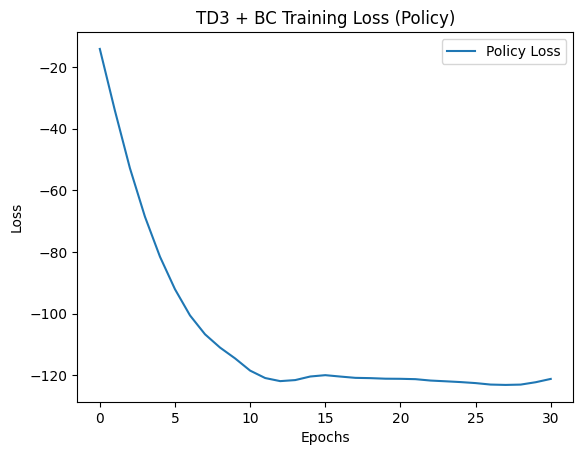

In [ ]:
from tensorboard.backend.event_processing import event_accumulator

ea = event_accumulator.EventAccumulator('./runs/TD3_BC')  
ea.Reload()

policy = ea.Scalars('Loss/Policy')
critic = ea.Scalars('Loss/Critic')

policy_losses = [x.value for x in policy]
critic_losses = [x.value for x in critic]

# Now you can plot
plt.title('TD3 + BC Training Loss (Policy)')
plt.plot(policy_losses, label='Policy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


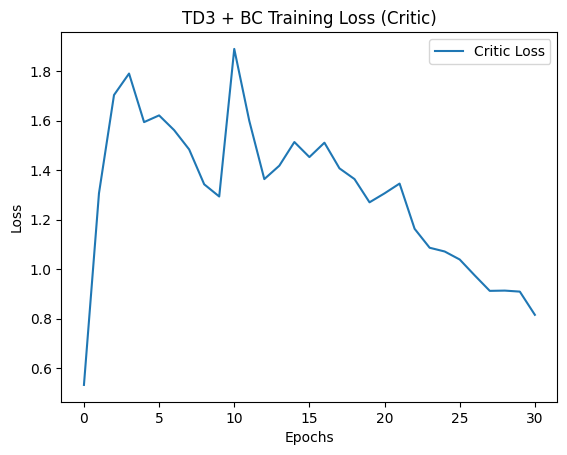

In [ ]:
plt.title("TD3 + BC Training Loss (Critic)")
plt.plot(critic_losses, label='Critic Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
